# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': 'e128b25ffedc234aa94ebc8a860a954b47f5436106ec95444e1ec453',
  'Alive': True,
  'NodeManagerAddress': '100.64.68.246',
  'NodeManagerHostname': 'ray-67914e5da12d5146bf75c2f2-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-01-22_12-02-54_578946_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-01-22_12-02-54_578946_1/sockets/raylet',
  'MetricsExportPort': 48448,
  'NodeName': '100.64.68.246',
  'alive': True,
  'Resources': {'object_store_memory': 4802752512.0,
   'node:100.64.68.246': 1.0,
   'CPU': 4.0,
   'memory': 11206422528.0}},
 {'NodeID': '48aa358c227694e16cb76da6478154181bec52012768198cb27b8122',
  'Alive': True,
  'NodeManagerAddress': '100.64.57.144',
  'NodeManagerHostname': 'ray-67914e5da12d5146bf75c2f2-ray-worker-1',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-01-22_12-02-54_578946_1/sockets/plasma_store',
  

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=2295) 2025-01-22 13:08:13,207	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=2295) 2025-01-22 13:08:18,751	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=354, ip=100.64.57.144) [13:08:18] task [xgboost.ray]:138341506828032 got new rank 0
(_RemoteRayXGBoostActor pid=532, ip=100.64.68.246) [13:08:18] task [xgboost.ray]:139941422175040 got new rank 1
(_RemoteRayXGBoostActor pid=746, ip=100.64.73.105) [13:08:19] task [xgboost.ray]:123685450634816 got new rank 2


(_wrapped pid=2295) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=2295) [1]	train-logloss:0.63109	train-error:0.22331	val-logloss:0.62514	val-error:0.20021
(_wrapped pid=2295) [2]	train-logloss:0.60870	train-error:0.22340	val-logloss:0.60081	val-error:0.20959
(_wrapped pid=2295) [3]	train-logloss:0.58690	train-error:0.18629	val-logloss:0.57680	val-error:0.15792
(_wrapped pid=2295) [4]	train-logloss:0.56898	train-error:0.19034	val-logloss:0.55650	val-error:0.16499
(_wrapped pid=2295) [5]	train-logloss:0.55210	train-error:0.20139	val-logloss:0.53913	val-error:0.17972
(_wrapped pid=2295) [6]	train-logloss:0.53646	train-error:0.18746	val-logloss:0.52258	val-error:0.16193
(_wrapped pid=2295) [7]	train-logloss:0.52353	train-error:0.18899	val-logloss:0.50922	val-error:0.16659
(_wrapped pid=2295) [8]	train-logloss:0.51097	train-error:0.17833	val-logloss:0.49647	val-error:0.15485
(_wrapped pid=2295) [9]	train-logloss:0.50000	train-error:0.1696

(_wrapped pid=2295) 2025-01-22 13:08:49,177	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(_wrapped pid=2295) [33]	train-logloss:0.34684	train-error:0.11448	val-logloss:0.33241	val-error:0.10723
(_wrapped pid=2295) [34]	train-logloss:0.34377	train-error:0.11517	val-logloss:0.32920	val-error:0.10568
(_wrapped pid=2295) [35]	train-logloss:0.33971	train-error:0.11360	val-logloss:0.32577	val-error:0.10412
(_wrapped pid=2295) [36]	train-logloss:0.33605	train-error:0.10761	val-logloss:0.32224	val-error:0.10097
(_wrapped pid=2295) [37]	train-logloss:0.33335	train-error:0.10382	val-logloss:0.31979	val-error:0.09627
(_wrapped pid=2295) [38]	train-logloss:0.32945	train-error:0.10460	val-logloss:0.31619	val-error:0.09786
(_wrapped pid=2295) [39]	train-logloss:0.32654	train-error:0.10505	val-logloss:0.31294	val-error:0.09787
(_wrapped pid=2295) [40]	train-logloss:0.32362	train-error:0.10278	val-logloss:0.31013	val-error:0.09549
(_wrapped pid=2295) [41]	train-logloss:0.32094	train-error:0.10403	val-logloss:0.30769	val-error:0.09625
(_wrapped pid=2295) [42]	train-logloss:0.31872	train-er

(_wrapped pid=2295) 2025-01-22 13:09:01,927	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 49.67 seconds (43.17 pure XGBoost training time).


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Demo-Credit-Default-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=2295) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=480, ip=100.64.57.144) [13:09:13] task [xgboost.ray]:134109961064560 got new rank 0
(_RemoteRayXGBoostActor pid=617, ip=100.64.68.246) [13:09:13] task [xgboost.ray]:124483186809680 got new rank 1
(_RemoteRayXGBoostActor pid=826, ip=100.64.73.105) [13:09:13] task [xgboost.ray]:134553366779888 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.62202	train-error:0.22747	val-logloss:0.61635	val-error:0.20883
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.57431	train-error:0.21497	val-logloss:0.56249	val-error:0.19395
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.53591	train-error:0.19640	val-logloss:0.52014	val-error:0.16812
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.50762	train-error:0.18495	val-logloss:0.49228	val-error:0.16196
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.48432	train-error:0.17501	val-logloss:0.46890	val-error:0.15794
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.46418	train-error:0.17130	val-logloss:0.44796	val-error:0.15181
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.44488	train-error:0.16024	val-logloss:0.43023	val-error:0.15093
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.42737	train-error:0.14706	val-logloss:0.41492	val-error:0.14393
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:09:44,126	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.25160	train-error:0.07977	val-logloss:0.24327	val-error:0.07507
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.24982	train-error:0.07964	val-logloss:0.24101	val-error:0.07431
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.24622	train-error:0.07762	val-logloss:0.23801	val-error:0.07430
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.24237	train-error:0.08034	val-logloss:0.23472	val-error:0.07739
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.23894	train-error:0.07483	val-logloss:0.23208	val-error:0.07586
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.23587	train-error:0.07181	val-logloss:0.22858	val-error:0.07352
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.23414	train-error:0.07215	val-logloss:0.22628	val-error:0.07352
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.23284	train-error:0.07136	val-logloss:0.22479	val-error:0.07352
(my_trai

(_RemoteRayXGBoostActor pid=662, ip=100.64.57.144) [13:10:03] task [xgboost.ray]:130278289458992 got new rank 0
(_RemoteRayXGBoostActor pid=700, ip=100.64.68.246) [13:10:03] task [xgboost.ray]:128227589576208 got new rank 1
(_RemoteRayXGBoostActor pid=906, ip=100.64.73.105) [13:10:03] task [xgboost.ray]:124037275727616 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.67809	train-error:0.30285	val-logloss:0.67722	val-error:0.29079
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.66459	train-error:0.26686	val-logloss:0.66267	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.65258	train-error:0.26686	val-logloss:0.64989	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.64171	train-error:0.27810	val-logloss:0.63801	val-error:0.26415
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.63119	train-error:0.26346	val-logloss:0.62661	val-error:0.24932
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.62173	train-error:0.26380	val-logloss:0.61656	val-error:0.24935
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.61281	train-error:0.25358	val-logloss:0.60689	val-error:0.23691
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.60445	train-error:0.25313	val-logloss:0.59799	val-error:0.23373
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:10:33,865	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.47794	train-error:0.19027	val-logloss:0.46814	val-error:0.18131
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.47511	train-error:0.19084	val-logloss:0.46555	val-error:0.18214
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.47227	train-error:0.18942	val-logloss:0.46268	val-error:0.18138
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.46891	train-error:0.18413	val-logloss:0.45906	val-error:0.17752
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.46605	train-error:0.18517	val-logloss:0.45599	val-error:0.17674
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.46328	train-error:0.18428	val-logloss:0.45300	val-error:0.17674
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.45988	train-error:0.18145	val-logloss:0.44938	val-error:0.17284
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.45776	train-error:0.17979	val-logloss:0.44727	val-error:0.17126
(my_trai

(_RemoteRayXGBoostActor pid=847, ip=100.64.57.144) [13:10:52] task [xgboost.ray]:127879341757440 got new rank 0
(_RemoteRayXGBoostActor pid=821, ip=100.64.68.246) [13:10:52] task [xgboost.ray]:138575971008464 got new rank 1
(_RemoteRayXGBoostActor pid=986, ip=100.64.73.105) [13:10:52] task [xgboost.ray]:140366920898352 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.68538	train-error:0.20367	val-logloss:0.68508	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.67789	train-error:0.20367	val-logloss:0.67724	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.67079	train-error:0.19528	val-logloss:0.66953	val-error:0.18459
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.66400	train-error:0.18766	val-logloss:0.66210	val-error:0.17522
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.65716	train-error:0.19486	val-logloss:0.65495	val-error:0.18371
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.65070	train-error:0.20152	val-logloss:0.64796	val-error:0.18692
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.64452	train-error:0.18505	val-logloss:0.64117	val-error:0.17137
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.63845	train-error:0.18616	val-logloss:0.63461	val-error:0.17380
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:11:23,229	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [32]	train-logloss:0.52632	train-error:0.17395	val-logloss:0.51530	val-error:0.15808
(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.52256	train-error:0.17148	val-logloss:0.51140	val-error:0.15421
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.51931	train-error:0.17352	val-logloss:0.50798	val-error:0.15731
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.51586	train-error:0.16821	val-logloss:0.50426	val-error:0.15186
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.51275	train-error:0.17035	val-logloss:0.50101	val-error:0.15494
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.50943	train-error:0.16750	val-logloss:0.49749	val-error:0.15103
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.50620	train-error:0.16480	val-logloss:0.49412	val-error:0.14633
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.50303	train-error:0.16425	val-logloss:0.49070	val-error:0.14319
(my_trai

(_RemoteRayXGBoostActor pid=1030, ip=100.64.57.144) [13:11:43] task [xgboost.ray]:133032216638992 got new rank 0
(_RemoteRayXGBoostActor pid=943, ip=100.64.68.246) [13:11:43] task [xgboost.ray]:139971304969696 got new rank 1
(_RemoteRayXGBoostActor pid=1067, ip=100.64.73.105) [13:11:43] task [xgboost.ray]:137517393861504 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.64279	train-error:0.22747	val-logloss:0.63890	val-error:0.20883
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.60503	train-error:0.22322	val-logloss:0.59661	val-error:0.20100
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.57369	train-error:0.19900	val-logloss:0.56201	val-error:0.17128
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.54940	train-error:0.18718	val-logloss:0.53551	val-error:0.15947
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.52774	train-error:0.18883	val-logloss:0.51249	val-error:0.16349
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.50947	train-error:0.18054	val-logloss:0.49409	val-error:0.16188
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.49346	train-error:0.17380	val-logloss:0.47898	val-error:0.15727
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.47921	train-error:0.17669	val-logloss:0.46454	val-error:0.15800
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:12:13,968	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.29230	train-error:0.09223	val-logloss:0.27944	val-error:0.07982
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.28926	train-error:0.09055	val-logloss:0.27648	val-error:0.07905
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.28487	train-error:0.09010	val-logloss:0.27113	val-error:0.07746
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.28123	train-error:0.09200	val-logloss:0.26714	val-error:0.07978
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.27909	train-error:0.08941	val-logloss:0.26539	val-error:0.07823
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.27598	train-error:0.08941	val-logloss:0.26196	val-error:0.07821
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.27340	train-error:0.08615	val-logloss:0.25964	val-error:0.07510
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.27104	train-error:0.08830	val-logloss:0.25756	val-error:0.07901
(my_trai

(_RemoteRayXGBoostActor pid=1215, ip=100.64.57.144) [13:12:32] task [xgboost.ray]:126090223900512 got new rank 0
(_RemoteRayXGBoostActor pid=1065, ip=100.64.68.246) [13:12:32] task [xgboost.ray]:139739628394432 got new rank 1
(_RemoteRayXGBoostActor pid=1186, ip=100.64.73.105) [13:12:32] task [xgboost.ray]:127452747225024 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.69029	train-error:0.20367	val-logloss:0.69018	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.68747	train-error:0.20367	val-logloss:0.68725	val-error:0.19787


(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.68469	train-error:0.20367	val-logloss:0.68436	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.68194	train-error:0.20367	val-logloss:0.68148	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.67923	train-error:0.20367	val-logloss:0.67867	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.67660	train-error:0.19304	val-logloss:0.67582	val-error:0.18065
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.67401	train-error:0.19304	val-logloss:0.67300	val-error:0.18065
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.67138	train-error:0.19304	val-logloss:0.67029	val-error:0.18065
(my_trainer pid=436, ip=100.64.57.144) [8]	train-logloss:0.66885	train-error:0.19528	val-logloss:0.66754	val-error:0.18459
(my_trainer pid=436, ip=100.64.57.144) [9]	train-logloss:0.66637	train-error:0.19520	val-logloss:0.66483	val-error:0.18294
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:13:03,359	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [32]	train-logloss:0.61548	train-error:0.17967	val-logloss:0.61008	val-error:0.15819
(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.61351	train-error:0.18069	val-logloss:0.60801	val-error:0.15896
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.61160	train-error:0.18069	val-logloss:0.60594	val-error:0.15819
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.60967	train-error:0.18138	val-logloss:0.60394	val-error:0.16054
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.60780	train-error:0.17967	val-logloss:0.60188	val-error:0.15819
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.60590	train-error:0.17916	val-logloss:0.59988	val-error:0.15740
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.60405	train-error:0.18084	val-logloss:0.59790	val-error:0.15975
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.60219	train-error:0.17723	val-logloss:0.59595	val-error:0.15662
(my_trai

(_RemoteRayXGBoostActor pid=1400, ip=100.64.57.144) [13:13:23] task [xgboost.ray]:124810528179776 got new rank 0
(_RemoteRayXGBoostActor pid=1148, ip=100.64.68.246) [13:13:23] task [xgboost.ray]:130754446376912 got new rank 1
(_RemoteRayXGBoostActor pid=1266, ip=100.64.73.105) [13:13:23] task [xgboost.ray]:135212657216336 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.62149	train-error:0.22747	val-logloss:0.61578	val-error:0.20883
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.57357	train-error:0.21497	val-logloss:0.56167	val-error:0.19395
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.53503	train-error:0.19640	val-logloss:0.51916	val-error:0.16812
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.50668	train-error:0.18495	val-logloss:0.49125	val-error:0.16196
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.48335	train-error:0.17501	val-logloss:0.46784	val-error:0.15794
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.46317	train-error:0.17130	val-logloss:0.44687	val-error:0.15181
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.44385	train-error:0.16024	val-logloss:0.42914	val-error:0.15093
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.42633	train-error:0.14706	val-logloss:0.41383	val-error:0.14393
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:13:54,261	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.24973	train-error:0.07691	val-logloss:0.23961	val-error:0.07114
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.24759	train-error:0.07590	val-logloss:0.23769	val-error:0.07193
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.24366	train-error:0.07424	val-logloss:0.23280	val-error:0.06801
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.24160	train-error:0.07378	val-logloss:0.22979	val-error:0.06801
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.23759	train-error:0.07391	val-logloss:0.22654	val-error:0.07036
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.23337	train-error:0.07333	val-logloss:0.22299	val-error:0.07115
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.23102	train-error:0.07223	val-logloss:0.22070	val-error:0.06725
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.22917	train-error:0.07053	val-logloss:0.21915	val-error:0.06646
(my_trai

(_RemoteRayXGBoostActor pid=1586, ip=100.64.57.144) [13:14:13] task [xgboost.ray]:133921348953664 got new rank 0
(_RemoteRayXGBoostActor pid=1312, ip=100.64.68.246) [13:14:14] task [xgboost.ray]:127430950364880 got new rank 1
(_RemoteRayXGBoostActor pid=1346, ip=100.64.73.105) [13:14:14] task [xgboost.ray]:137448952518640 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.67715	train-error:0.22747	val-logloss:0.67597	val-error:0.20883
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.66297	train-error:0.22331	val-logloss:0.66016	val-error:0.20021
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.64998	train-error:0.21114	val-logloss:0.64551	val-error:0.18773
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.63722	train-error:0.21758	val-logloss:0.63173	val-error:0.19398
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.62640	train-error:0.21565	val-logloss:0.62001	val-error:0.20100
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.61593	train-error:0.20920	val-logloss:0.60830	val-error:0.19554
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.60649	train-error:0.20672	val-logloss:0.59787	val-error:0.19316
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.59685	train-error:0.20423	val-logloss:0.58751	val-error:0.18924
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:14:44,531	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.45410	train-error:0.16175	val-logloss:0.44023	val-error:0.14797
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.45047	train-error:0.16267	val-logloss:0.43661	val-error:0.14876
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.44717	train-error:0.15691	val-logloss:0.43338	val-error:0.14329
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.44340	train-error:0.15693	val-logloss:0.42961	val-error:0.14410
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.44049	train-error:0.15378	val-logloss:0.42673	val-error:0.14016
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.43638	train-error:0.15525	val-logloss:0.42238	val-error:0.14099
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.43319	train-error:0.15298	val-logloss:0.41913	val-error:0.14015
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.42961	train-error:0.15141	val-logloss:0.41532	val-error:0.14018
(my_trai

(_RemoteRayXGBoostActor pid=1811, ip=100.64.57.144) [13:15:03] task [xgboost.ray]:135411196557152 got new rank 0
(_RemoteRayXGBoostActor pid=1392, ip=100.64.68.246) [13:15:03] task [xgboost.ray]:138846288304016 got new rank 1
(_RemoteRayXGBoostActor pid=1430, ip=100.64.73.105) [13:15:03] task [xgboost.ray]:135510742346576 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.67193	train-error:0.20367	val-logloss:0.67111	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.65299	train-error:0.19621	val-logloss:0.65065	val-error:0.18534
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.63587	train-error:0.18597	val-logloss:0.63174	val-error:0.17371
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.61945	train-error:0.18807	val-logloss:0.61470	val-error:0.17453
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.60477	train-error:0.18795	val-logloss:0.59858	val-error:0.16907
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.59082	train-error:0.18047	val-logloss:0.58385	val-error:0.16593
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.57747	train-error:0.18087	val-logloss:0.56953	val-error:0.16511
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.56536	train-error:0.17283	val-logloss:0.55605	val-error:0.15031
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:15:34,120	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [32]	train-logloss:0.38726	train-error:0.11631	val-logloss:0.37263	val-error:0.10259
(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.38299	train-error:0.11599	val-logloss:0.36858	val-error:0.10183
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.37877	train-error:0.11246	val-logloss:0.36433	val-error:0.10104
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.37452	train-error:0.11733	val-logloss:0.36009	val-error:0.10415
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.37073	train-error:0.11293	val-logloss:0.35641	val-error:0.10106
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.36717	train-error:0.10875	val-logloss:0.35272	val-error:0.09711
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.36301	train-error:0.11053	val-logloss:0.34841	val-error:0.09944
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.35945	train-error:0.11279	val-logloss:0.34497	val-error:0.10099
(my_trai

(_RemoteRayXGBoostActor pid=1997, ip=100.64.57.144) [13:15:54] task [xgboost.ray]:138748212356912 got new rank 0
(_RemoteRayXGBoostActor pid=1472, ip=100.64.68.246) [13:15:54] task [xgboost.ray]:124197827860272 got new rank 1
(_RemoteRayXGBoostActor pid=1591, ip=100.64.73.105) [13:15:54] task [xgboost.ray]:139709661312816 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.68874	train-error:0.30285	val-logloss:0.68849	val-error:0.29079
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.68449	train-error:0.26686	val-logloss:0.68393	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.68036	train-error:0.26686	val-logloss:0.67956	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.67638	train-error:0.26686	val-logloss:0.67528	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.67250	train-error:0.26686	val-logloss:0.67117	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.66876	train-error:0.26686	val-logloss:0.66720	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.66512	train-error:0.26686	val-logloss:0.66327	val-error:0.24841
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.66160	train-error:0.26916	val-logloss:0.65929	val-error:0.24766
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:16:24,637	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.59213	train-error:0.24894	val-logloss:0.58567	val-error:0.23061
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.59009	train-error:0.24894	val-logloss:0.58344	val-error:0.23061
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.58804	train-error:0.24894	val-logloss:0.58125	val-error:0.23061
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.58604	train-error:0.24894	val-logloss:0.57928	val-error:0.23061
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.58412	train-error:0.24894	val-logloss:0.57719	val-error:0.23061
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.58226	train-error:0.24064	val-logloss:0.57517	val-error:0.22596
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.58034	train-error:0.24064	val-logloss:0.57330	val-error:0.22596
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.57854	train-error:0.23548	val-logloss:0.57144	val-error:0.21971
(my_trai

(_RemoteRayXGBoostActor pid=1554, ip=100.64.68.246) [13:16:44] task [xgboost.ray]:133426296850176 got new rank 1
(_RemoteRayXGBoostActor pid=2219, ip=100.64.57.144) [13:16:44] task [xgboost.ray]:137897389502080 got new rank 0
(_RemoteRayXGBoostActor pid=1674, ip=100.64.73.105) [13:16:44] task [xgboost.ray]:140037142009552 got new rank 2


(my_trainer pid=436, ip=100.64.57.144) [0]	train-logloss:0.59318	train-error:0.20367	val-logloss:0.58916	val-error:0.19787
(my_trainer pid=436, ip=100.64.57.144) [1]	train-logloss:0.52976	train-error:0.18205	val-logloss:0.52126	val-error:0.16815
(my_trainer pid=436, ip=100.64.57.144) [2]	train-logloss:0.48081	train-error:0.16916	val-logloss:0.46864	val-error:0.14710
(my_trainer pid=436, ip=100.64.57.144) [3]	train-logloss:0.44446	train-error:0.16005	val-logloss:0.43359	val-error:0.14940
(my_trainer pid=436, ip=100.64.57.144) [4]	train-logloss:0.41403	train-error:0.13992	val-logloss:0.40292	val-error:0.13447
(my_trainer pid=436, ip=100.64.57.144) [5]	train-logloss:0.38659	train-error:0.12357	val-logloss:0.37725	val-error:0.11967
(my_trainer pid=436, ip=100.64.57.144) [6]	train-logloss:0.36552	train-error:0.11375	val-logloss:0.35520	val-error:0.10943
(my_trainer pid=436, ip=100.64.57.144) [7]	train-logloss:0.34732	train-error:0.11102	val-logloss:0.33868	val-error:0.10643
(my_trainer pid=

(my_trainer pid=436, ip=100.64.57.144) 2025-01-22 13:17:15,325	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=436, ip=100.64.57.144) [33]	train-logloss:0.15571	train-error:0.03309	val-logloss:0.14958	val-error:0.03053
(my_trainer pid=436, ip=100.64.57.144) [34]	train-logloss:0.15346	train-error:0.03186	val-logloss:0.14716	val-error:0.03135
(my_trainer pid=436, ip=100.64.57.144) [35]	train-logloss:0.15136	train-error:0.02970	val-logloss:0.14566	val-error:0.03056
(my_trainer pid=436, ip=100.64.57.144) [36]	train-logloss:0.14786	train-error:0.02836	val-logloss:0.14177	val-error:0.02901
(my_trainer pid=436, ip=100.64.57.144) [37]	train-logloss:0.14275	train-error:0.02224	val-logloss:0.13715	val-error:0.02117
(my_trainer pid=436, ip=100.64.57.144) [38]	train-logloss:0.13991	train-error:0.02203	val-logloss:0.13378	val-error:0.02041
(my_trainer pid=436, ip=100.64.57.144) [39]	train-logloss:0.13741	train-error:0.02203	val-logloss:0.13108	val-error:0.02041
(my_trainer pid=436, ip=100.64.57.144) [40]	train-logloss:0.13294	train-error:0.02293	val-logloss:0.12687	val-error:0.02274
(my_trai

Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

(run pid=2295) 2025-01-22 13:17:31,874	INFO tune.py:945 -- Total run time: 509.35 seconds (505.63 seconds for the tuning loop).


{'seed': 1234,
 'eta': 0.25935389508229717,
 'max_depth': 4,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=2295) 2025-01-22 13:17:32,014	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=2295) 2025-01-22 13:17:33,972	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.74


In [18]:
list(predictions)

[0.62294513,
 0.9947221,
 0.46433616,
 0.9909691,
 0.99893576,
 0.8005355,
 0.6318102,
 0.7497124,
 0.9423289,
 0.9024571,
 0.772838,
 0.20990156,
 0.90214413,
 0.96375364,
 0.4158517,
 0.19486938,
 0.911944,
 0.7610031,
 0.98438036,
 0.8860899,
 0.45795864,
 0.94359994,
 0.6061675,
 0.9869971,
 0.6671437,
 0.99088025,
 0.24690391,
 0.35693398,
 0.97175705,
 0.09470186,
 0.9771185,
 0.5811446,
 0.39013395,
 0.9648993,
 0.91662955,
 0.49831674,
 0.99927074,
 0.98087764,
 0.4986358,
 0.9794094,
 0.26043418,
 0.9502843,
 0.3170344,
 0.3458715,
 0.93077224,
 0.5769257,
 0.9965759,
 0.81180435,
 0.69903165,
 0.9823965,
 0.9215989,
 0.99675554,
 0.88892573,
 0.95102334,
 0.9530122,
 0.08863904,
 0.99312854,
 0.81736016,
 0.7932167,
 0.99633574,
 0.5413999,
 0.7929333,
 0.6131318,
 0.40053117,
 0.7718596,
 0.2717645,
 0.956162,
 0.26243725,
 0.2711593,
 0.44177783,
 0.9679423,
 0.62191683,
 0.587575,
 0.9962813,
 0.8798083,
 0.8438413,
 0.62056905,
 0.2986713,
 0.959331,
 0.95248955,
 0.89167

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.74


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

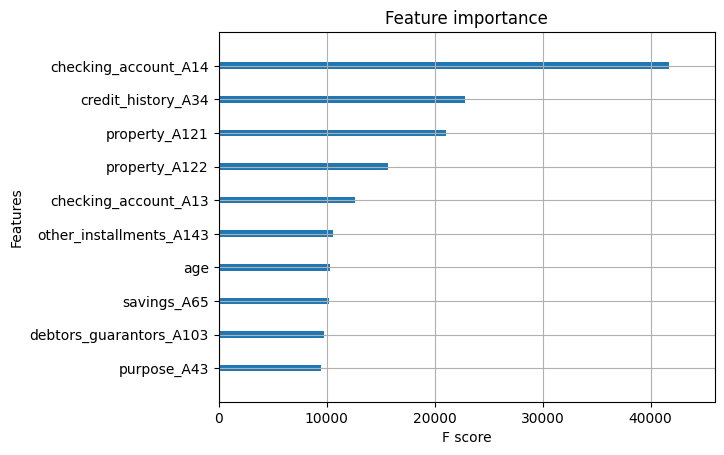

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

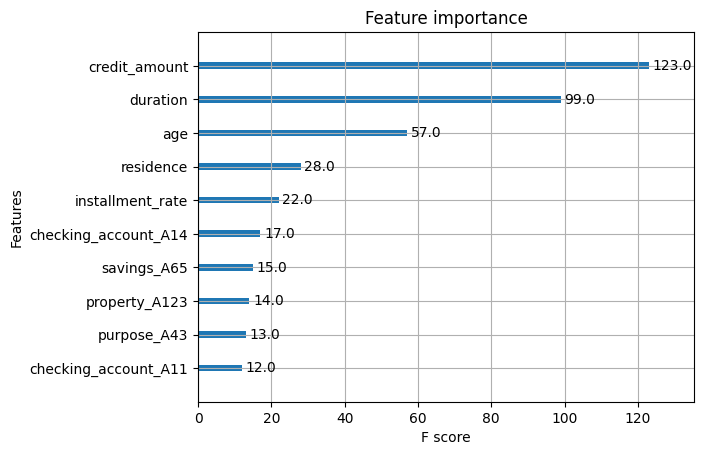

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

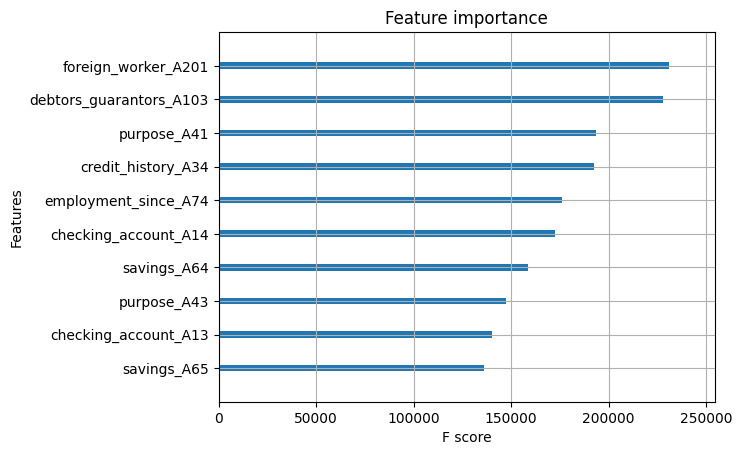

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.1092,checking_account_A14
0.0596,credit_history_A34
0.0550,property_A121
0.0410,property_A122
0.0331,checking_account_A13
0.0277,other_installments_A143
0.0269,age
0.0267,savings_A65
0.0255,debtors_guarantors_A103
0.0249,purpose_A43


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,1.144145,1.000000
y,age,0.537345,0.285714
y,credit_amount,0.367819,0.368548
y,status_A93,0.351433,1.000000
y,employment_since_A73,0.211253,1.000000
y,telephone_A192,0.210492,1.000000
y,employment_since_A72,0.147969,0.000000
y,installment_rate,0.134525,0.333333
y,property_A122,0.100296,0.000000
y,property_A123,0.087997,1.000000
